<a href="https://colab.research.google.com/github/kimsooyoung/deep-reinforcement-learning-gymnasium/blob/main/temporal-difference/Temporal_Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
import unittest
from IPython.display import Markdown, display
import numpy as np

def printmd(string):
    display(Markdown(string))

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

def get_long_path(V):
    return np.array(np.hstack((V[0:13][0], V[1][0], V[1][11], V[2][0], V[2][11], V[3][0], V[3][11])))

def get_optimal_path(policy):
    return np.array(np.hstack((policy[2][:], policy[3][0])))

class Tests(unittest.TestCase):

    def td_prediction_check(self, V):
        to_check = get_long_path(V)
        soln = get_long_path(V_true)
        np.testing.assert_array_almost_equal(soln, to_check)

    def td_control_check(self, policy):
        to_check = get_optimal_path(policy)
        np.testing.assert_equal(pol_opt, to_check)

check = Tests()

def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')

In [2]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()

In [ ]:
# @title
!pip install gymnasium

# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [4]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [5]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [6]:
print(env.unwrapped.nA)
print(env.action_space)
print(env.observation_space)

4
Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

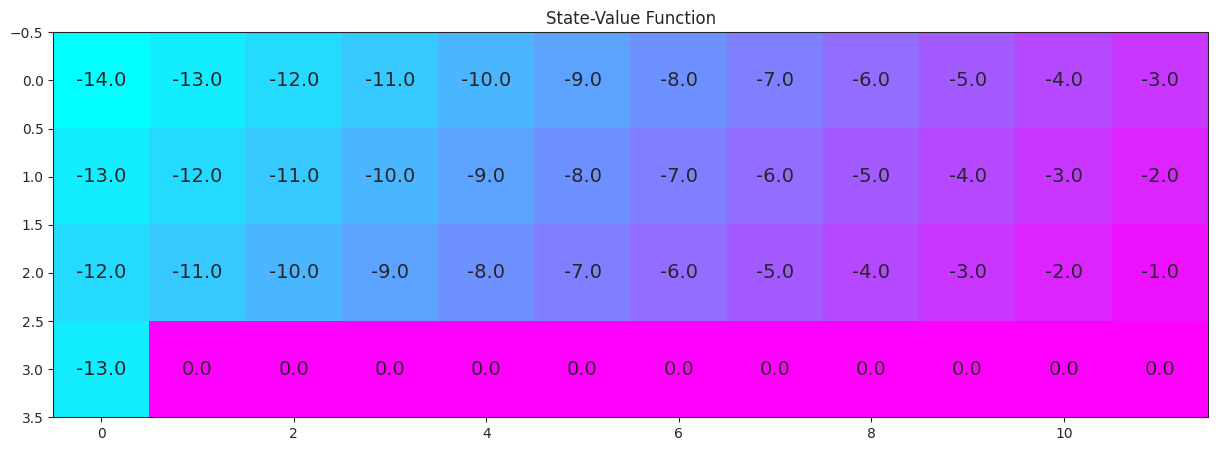

In [15]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

## Explore environment

In [16]:
for i_episode in range(1):
    state = env.reset()
    print(f'initial state : {state}')
    episode = []
    while True:
        action = env.action_space.sample()
        state, reward, done, info, prob = env.step(action)
        episode.append((state, action, reward))
        if done:
            print('End game! Episode: ', episode)
            break

initial state : (36, {'prob': 1})
End game! Episode:  [(36, 1, -100), (24, 0, -1), (24, 3, -1), (12, 0, -1), (0, 0, -1), (0, 0, -1), (0, 3, -1), (1, 1, -1), (1, 0, -1), (1, 0, -1), (2, 1, -1), (3, 1, -1), (4, 1, -1), (5, 1, -1), (5, 0, -1), (5, 0, -1), (5, 0, -1), (5, 0, -1), (17, 2, -1), (29, 2, -1), (36, 2, -100), (24, 0, -1), (36, 2, -1), (36, 2, -1), (24, 0, -1), (24, 3, -1), (24, 3, -1), (12, 0, -1), (0, 0, -1), (1, 1, -1), (0, 3, -1), (0, 3, -1), (1, 1, -1), (13, 2, -1), (1, 0, -1), (1, 0, -1), (0, 3, -1), (1, 1, -1), (1, 0, -1), (0, 3, -1), (0, 0, -1), (1, 1, -1), (2, 1, -1), (1, 3, -1), (13, 2, -1), (12, 3, -1), (13, 1, -1), (14, 1, -1), (15, 1, -1), (3, 0, -1), (15, 2, -1), (3, 0, -1), (4, 1, -1), (16, 2, -1), (4, 0, -1), (3, 3, -1), (4, 1, -1), (16, 2, -1), (15, 3, -1), (3, 0, -1), (4, 1, -1), (3, 3, -1), (15, 2, -1), (3, 0, -1), (4, 1, -1), (4, 0, -1), (4, 0, -1), (4, 0, -1), (4, 0, -1), (3, 3, -1), (2, 3, -1), (14, 2, -1), (2, 0, -1), (1, 3, -1), (2, 1, -1), (3, 1, -1), (15

### Episode Generation
하지만, SARSA는 Episode가 다 끝나고 돌리는 것이 아니기 때문에 이런 식으로 구현하면 안됨!

In [17]:
def get_prob(Q_cur, epsilon):
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s
    return output

def generate_episode_greedy_policy(bj_env, Q, epsilon):
    episode = []
    state = bj_env.reset()
    while True:
        # if first visit, don't need to adapt greedy policies
        if state in Q:
          probs = get_prob(Q[state], epsilon)
          action = np.random.choice(np.arange(bj_env.nA), p=probs)
        else:
          action = bj_env.action_space.sample()

        next_state, reward, done, info, prob = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

## SARSA Implementation

In [19]:
def greedy_policy_prob(Q, state, epsilon, nA):

    # if state in Q:
    #   Q_cur = Q[state]
    # else:
    #   return np.ones(nA) / nA

    Q_cur = Q[state]
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s
    return output

def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    action_number = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(action_number))
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        state, _ = env.reset()
        epsilon = 1.0 / i_episode

        # first action
        prob = greedy_policy_prob(Q, state, epsilon, action_number)
        action = np.random.choice(np.arange(action_number), p=prob)

        while True:
            # take action
            next_state, reward, done, info, _ = env.step(action)

            # update Q table
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            else:
                # get prob for greedy_policy
                prob = greedy_policy_prob(Q, next_state, epsilon, action_number)
                # choose next action
                next_action = np.random.choice(np.arange(action_number), p=prob)
                # SARSA
                Q[state][action] = Q[state][action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
                # state update
                state = next_state
                action = next_action
                # print(state)
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
Q_sarsa = sarsa(env, 3, .01)
Q_sarsa

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  2  0  1  1  0  1  1  1  2]
 [ 0  0  0  1  1  1  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


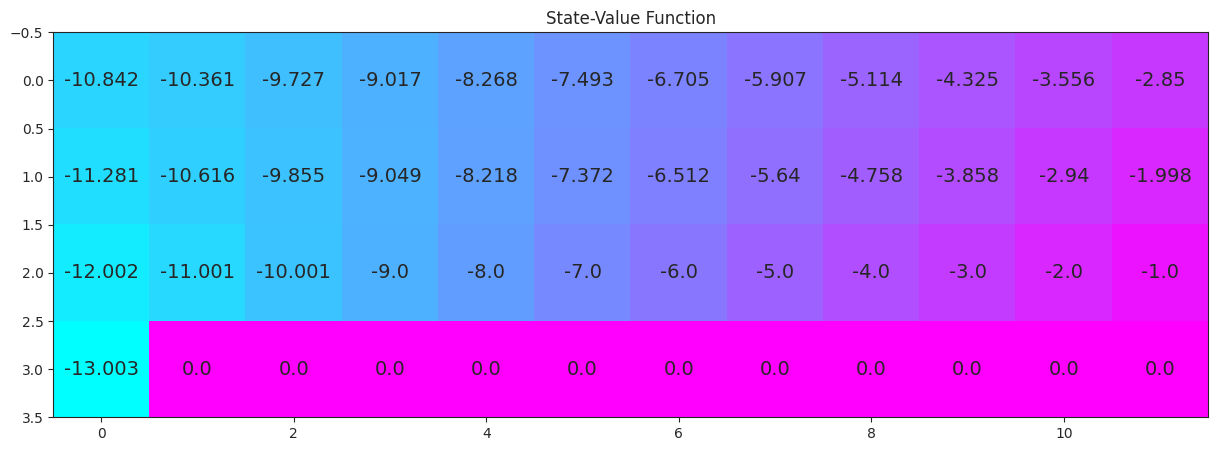

In [22]:
# @title
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

policy는 greedy policy 그대로, Q table을 next action의 Max Value를 사용해서 업데이트 한다.

In [17]:
def greedy_policy_prob(Q, state, epsilon, nA):
    Q_cur = Q[state]
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s
    return output

def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    action_number = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        state, _ = env.reset()
        epsilon = 1.0 / i_episode

        # S_0
        prob = greedy_policy_prob(Q, state, epsilon, action_number)
        action =  np.random.choice(np.arange(action_number), p=prob)

        while True:
            # A_0, R_0 take action
            next_state, reward, done, info, _ = env.step(action)

            # update Q table
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            else:
                # S_1, A_1
                # get prob for greedy_policy & choose next action
                prob = greedy_policy_prob(Q, next_state, epsilon, action_number)
                next_action = np.random.choice(np.arange(action_number), p=prob)

                next_Q = np.max(Q[next_state])
                Q[state][action] = Q[state][action] + alpha * (reward + gamma * next_Q - Q[state][action])

            # state/action update
            state = next_state
            action = next_action
            # print(state)

    return Q


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Test Code with small iteration

In [18]:
env = gym.make('CliffWalking-v0')
Q_sarsamax = q_learning(env, 1, .01)
Q_sarsamax

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {36: array([  -2.42175677, -102.07324481,   -3.23509259,   -3.20472821]),
             24: array([-2.08373763, -1.58518758, -2.90706732, -2.12852751]),
             12: array([-1.69919046, -1.55605019, -1.87119368, -1.78083711]),
             0: array([-1.46356174, -1.51841625, -1.70019523, -1.29989801]),
             1: array([-1.40829634, -1.27068798, -1.38286186, -1.31462809]),
             2: array([-1.10164009, -0.90914886, -0.93324949, -1.19862242]),
             14: array([-0.92660143, -0.7623422 , -0.78933665, -0.97762627]),
             13: array([-1.46622438, -1.14718939, -1.12183453, -1.54130829]),
             25: array([ -1.27564408,  -0.85133186, -75.02858093,  -1.46933171]),
             26: array([ -0.66076067,  -0.52214477, -43.14859099,  -0.64507501]),
             27: array([ -0.40931183,  -0.28121767, -36.99716847,  -0.31714866]),
             15: array([-0.521032  , -0.44733188, -0.51571849

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  2  1  1  1  2  1  3  1  1  2]
 [ 3  1  1  1  2  1  2  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


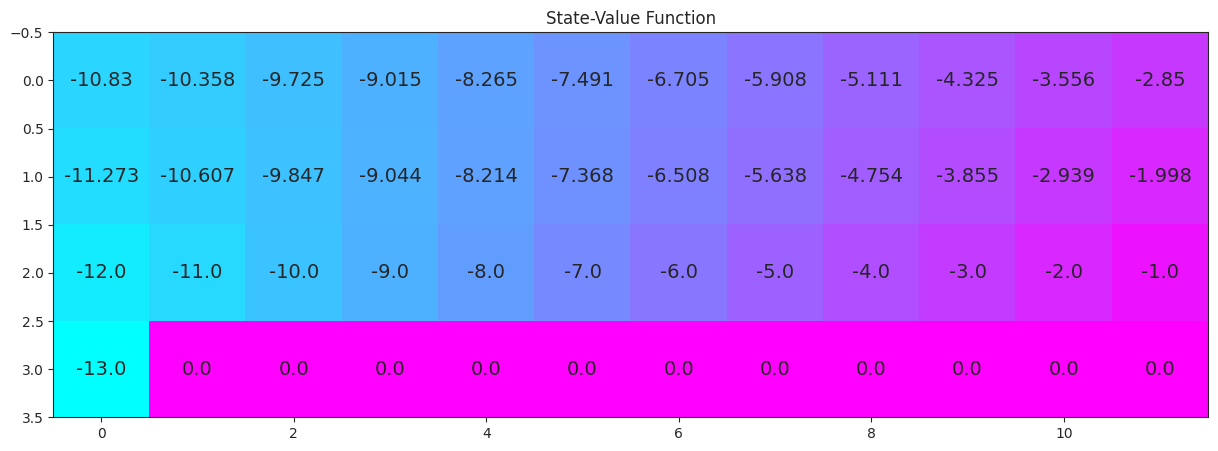

In [19]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

 ## *Caution!!*

 Expected Sarsa requires fixed small epsilon for greedy policy.

In [36]:
def greedy_policy_prob(Q, state, epsilon, nA):

    Q_cur = Q[state]
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s

    return output

def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    action_number = env.unwrapped.nA
    Q = defaultdict(lambda: np.zeros(env.nA))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # S_0
        state, _ = env.reset()
        # epsilon = 1.0 / i_episode
        epsilon = 0.0001

        while True:
            # A_0
            prob = greedy_policy_prob(Q, state, epsilon, action_number)
            action = np.random.choice(np.arange(action_number), p=prob)

            # R_0, S_1
            next_state, reward, done, info, _ = env.step(action)

            # A_1
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            else:
                prob = greedy_policy_prob(Q, next_state, epsilon, action_number)
                next_action = np.random.choice(np.arange(action_number), p=prob)

                exp_Q = np.dot(Q[next_state], prob)
                # print(Q[next_state], prob)
                Q[state][action] = Q[state][action] + alpha * (reward + gamma * exp_Q - Q[state][action])

            # state update
            state = next_state
            action = next_action
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

### Test code with small iter

In [37]:
env = gym.make('CliffWalking-v0')
Q_sarsamax = expected_sarsa(env, 2, .01)
Q_sarsamax

defaultdict(<function __main__.expected_sarsa.<locals>.<lambda>()>,
            {36: array([-0.29164879, -1.        , -0.29000628, -0.29000635]),
             24: array([-0.20399313, -0.21163374, -0.20222308, -0.2100001 ]),
             12: array([-0.15799642, -0.15809341, -0.16484247, -0.16000009]),
             0: array([-0.14000003, -0.14869709, -0.14181365, -0.14000008]),
             1: array([-0.13000002, -0.13805157, -0.13023578, -0.13157766]),
             2: array([-0.11000002, -0.11843222, -0.1100478 , -0.11166175]),
             3: array([-0.09000002, -0.09881583, -0.08998608, -0.09138207]),
             4: array([-0.07000002, -0.07911384, -0.0699885 , -0.07097625]),
             5: array([-0.05000001, -0.05950498, -0.05999308, -0.05059296]),
             6: array([-0.04      , -0.049702  , -0.03999901, -0.04039897]),
             7: array([-0.03      , -0.039801  , -0.03000001, -0.03020103]),
             8: array([-0.03      , -0.02990001, -0.02      , -0.02010001]),
     

Episode 20000/20000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  0  1  1  1  2  0  1  1  3]
 [ 2  1  1  0  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


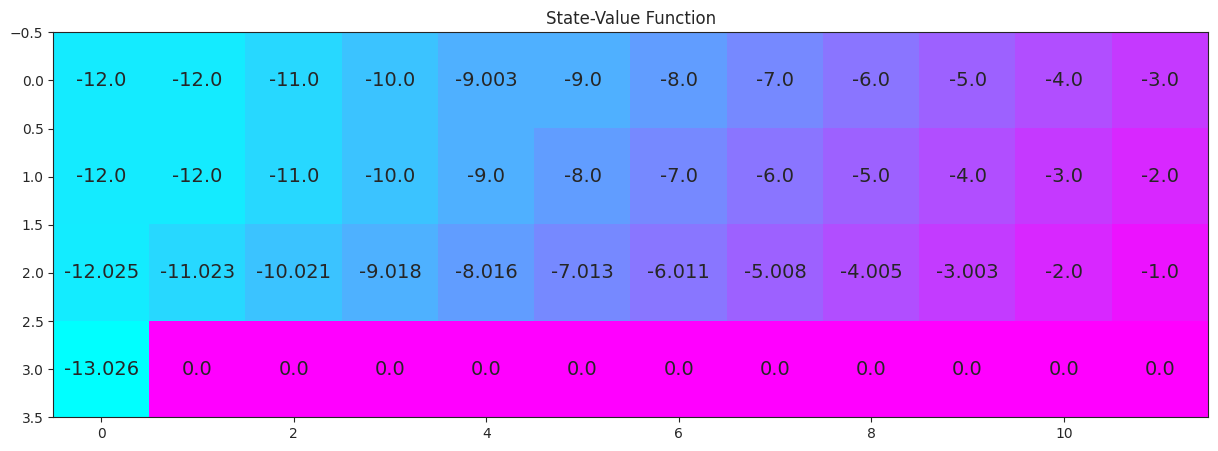

In [38]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 20000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])